ANALYZING THE AVOCADO INDUSTRY

By Xiangzhen He, Katherine Hurtado-da Silva and Jazmin Logroño

California, the state with the largest avocado production, has been suffering from an increase in droughts and wildfires in recent years. Historical production, pricing, and climate changes were analyzed to determine how the avocado industry is expected to change in the future in order to meet demand and mitigate significant fluctuations in average avocado prices across the United States.

The California Avocado Production data set provided by Kaggle at https://www.kaggle.com/datasets/jarredpriester/california-avocado-production-19802020 was used to perform the analysis. The ARIMA models will be created to analyze statewide and countywide avocado productions and prices.

Discussions about temperature, precipitation and wildfire impacts on avocado production and prices, and analysis performed to evaluate avocado prices in different States throughout 2015-2018 were conducted by the other two teammates and thereform not included in this document.

In [1]:
#load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from matplotlib import rcParams

#import math
import pmdarima as pm

import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px

from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

In [2]:
#load avocado data set
adf= pd.read_csv('Data/cali_avocados.csv')

In [3]:
#review the records
print(adf.shape)
print(adf[:20])

(420, 11)
    Year   Commodity Code      Crop Name   County Code            County  \
0   2020           221999  AVOCADOS ALL             53         Monterey    
1   2020           221999  AVOCADOS ALL             65        Riverside    
2   2020           221999  AVOCADOS ALL             71   San Bernardino    
3   2020           221999  AVOCADOS ALL             73        San Diego    
4   2020           221999  AVOCADOS ALL             79  San Luis Obispo    
5   2020           221999  AVOCADOS ALL             83    Santa Barbara    
6   2020           221999  AVOCADOS ALL            111          Ventura    
7   2019           221999  AVOCADOS ALL             53         Monterey    
8   2019           221999  AVOCADOS ALL             65        Riverside    
9   2019           221999  AVOCADOS ALL             71   San Bernardino    
10  2019           221999  AVOCADOS ALL             73        San Diego    
11  2019           221999  AVOCADOS ALL             79  San Luis Obispo    
12

In [4]:
#check the data type of each column
adf.dtypes #column names have spaces before names #numerical data types needed

Year                 int64
 Commodity Code      int64
 Crop Name          object
 County Code         int64
 County             object
 Harvested Acres    object
 Yield              object
 Production         object
 Price P/U          object
 Unit               object
 Value              object
dtype: object

In [5]:
#review the column names
print(adf.columns) #found there are extra spaces in the column names

Index(['Year', ' Commodity Code', ' Crop Name', ' County Code', ' County',
       ' Harvested Acres', ' Yield', ' Production', ' Price P/U', ' Unit',
       ' Value'],
      dtype='object')


In [6]:
#Remove whitespace from column name
adf.columns = adf.columns.str.replace(' ', '')

In [7]:
adf.dtypes #column names fixed

Year               int64
CommodityCode      int64
CropName          object
CountyCode         int64
County            object
HarvestedAcres    object
Yield             object
Production        object
PriceP/U          object
Unit              object
Value             object
dtype: object

In [8]:
#removing whitespace from values 
for column in adf.columns[4:]:
    adf[column]=adf[column].str.strip()

In [9]:
print(adf['Year'].unique()) #20 year span
print(adf['CommodityCode'].unique()) #drop it is the same throughout
print(adf['CropName'].unique()) #drop its basically the same
print(adf['CountyCode'].unique()) #keep just in case
print(adf['County'].unique()) #requires strip() to avoid county duplicates
print(adf['Unit'].unique()) #drop basically the same

[2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008 2007
 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994 1993
 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981 1980]
[221999]
['AVOCADOS ALL ' 'AVOCADOS ALL']
[ 53  65  71  73  79  83 111 991  37  59 107  87   7  19  69  99  29  85]
['Monterey' 'Riverside' 'San Bernardino' 'San Diego' 'San Luis Obispo'
 'Santa Barbara' 'Ventura' 'Sum of Others' 'San Luis Obisp' 'Los Angeles'
 'Orange' 'Tulare' 'Santa Cruz' 'Butte' 'Fresno' 'San Benito' 'Stanislaus'
 'Kern' 'Santa Clara']
['Tons' '' 'tons' 'TONS' 'TON']


In [10]:
# San Luis Obispo and San Luis Obisp are the same and need to have their names aligned
adf=adf.replace({'County':{'San Luis Obisp':'San Luis Obispo'}})
print(adf['County'].unique()) 

['Monterey' 'Riverside' 'San Bernardino' 'San Diego' 'San Luis Obispo'
 'Santa Barbara' 'Ventura' 'Sum of Others' 'Los Angeles' 'Orange' 'Tulare'
 'Santa Cruz' 'Butte' 'Fresno' 'San Benito' 'Stanislaus' 'Kern'
 'Santa Clara']


In [11]:
#Drop columms not needed
adf = adf.drop(['CommodityCode','CropName','Unit'], axis=1) 
print(adf.shape)

(420, 8)


In [12]:
#check if there are null values in the data
print(adf.isnull().sum()) #not picking up on empty cells

Year              0
CountyCode        0
County            0
HarvestedAcres    0
Yield             0
Production        0
PriceP/U          0
Value             0
dtype: int64


In [13]:
# Replacing empty cells with NaN
adf = adf.replace(r'^\s*$', np.nan,regex=True)

#Identifying rows with NaN values
print(adf[adf.isnull().any(axis=1)])

#Identifying the number of rows with NaN values
print(len(adf[adf.isnull().any(axis=1)]))

     Year  CountyCode         County HarvestedAcres Yield Production PriceP/U  \
1    2020          65      Riverside           3020   NaN        NaN      NaN   
14   2019         991  Sum of Others           1151   NaN        NaN      NaN   
205  1998         991  Sum of Others             86   NaN        NaN      NaN   
216  1997         991  Sum of Others            108   NaN        NaN      NaN   
247  1994         991  Sum of Others              4   NaN        NaN      NaN   
258  1993         991  Sum of Others             13   NaN        NaN      NaN   
260  1992          53       Monterey            NaN   NaN        NaN      NaN   
270  1991          53       Monterey            NaN   NaN        NaN      NaN   
277  1991          87     Santa Cruz            NaN   NaN        NaN      NaN   
278  1991         107         Tulare            NaN   NaN        NaN      NaN   
291  1990         991  Sum of Others             10   NaN        NaN      NaN   
303  1989         991  Sum o

In [14]:
# Adjust data types 
for column in ['HarvestedAcres','Yield','Production','PriceP/U','Value']:
    adf[column]=adf[column].astype('float64',errors='raise')
print(adf.dtypes)

Year                int64
CountyCode          int64
County             object
HarvestedAcres    float64
Yield             float64
Production        float64
PriceP/U          float64
Value             float64
dtype: object


In [15]:
#check null values in the data again
print(adf.isnull().sum())

Year               0
CountyCode         0
County             0
HarvestedAcres    18
Yield             26
Production        26
PriceP/U          26
Value             18
dtype: int64


In [16]:
#dropping rows that has any missing values
droprows=adf[adf.isna().any(axis=1)].index
adf.drop(droprows, inplace=True)

#adf = adf.interpolate()

### Exploratory Data Analysis: Main Data Set

In [17]:
#number of counties
len(adf['County'].unique())

14

In [18]:
#print(sb.color_palette("mako").as_hex())

In [19]:
adf['County'].value_counts().index

Index(['San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara',
       'Ventura', 'Riverside', 'Monterey', 'Los Angeles', 'Orange', 'Tulare',
       'Sum of Others', 'Santa Cruz', 'Fresno', 'Kern'],
      dtype='object')

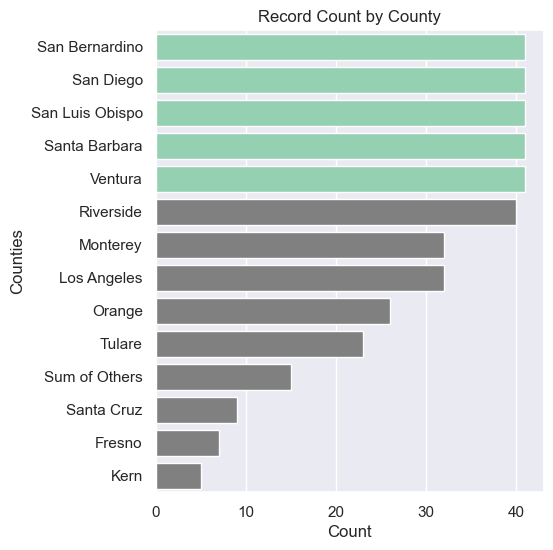

In [20]:
# Countplot of Counties for each year
sb.set(font_scale=1)
sb.set_style('darkgrid')
plt.gcf().set_size_inches(5, 6)

Sentdist=sb.countplot(data=adf, y='County',palette=['#8bdab2','#8bdab2','#8bdab2','#8bdab2','#8bdab2','#808080','#808080',
                                            '#808080','#808080','#808080','#808080','#808080','#808080','#808080'],
                      order = adf['County'].value_counts().index)

plt.title('Record Count by County')
plt.xlabel('Count')
plt.ylabel('Counties')
plt.show()

In [21]:
# exploratory data analysis: plot of values over the years
# perform groupby
grouped_df = adf.groupby(['Year']).agg({"Yield": ['mean','sum'],"Production": ['mean','sum'], 
                                       "PriceP/U" : 'mean', "Value": "mean",
                                       "HarvestedAcres": ['sum']})
grouped_df.columns = ['Average_Yield','Total_Yield','Average_Production','Total_Production', 'Average_PriceP/U', 'Average_Value', 'Total_HarvestedAcres']
grouped_df = grouped_df.reset_index()

#set Year column as index
grouped_df['Year'] = grouped_df['Year'].astype(str)
grouped_df = grouped_df.set_index('Year')
print(grouped_df)

      Average_Yield  Total_Yield  Average_Production  Total_Production  \
Year                                                                     
1980       2.030909        22.34         8635.636364           94992.0   
1981       3.712727        40.84        19750.363636          217254.0   
1982       3.008333        36.10        18671.500000          224058.0   
1983       3.045833        36.55        21358.583333          256303.0   
1984       2.452500        29.43        24024.083333          288289.0   
1985       2.607273        28.68        21003.636364          231040.0   
1986       2.200000        24.20        19128.363636          210412.0   
1987       3.138182        34.52        25755.727273          283313.0   
1988       2.684545        29.53        18919.181818          208111.0   
1989       2.132727        23.46        14894.181818          163836.0   
1990       1.958182        21.54        10707.454545          117782.0   
1991       1.996250        15.97      

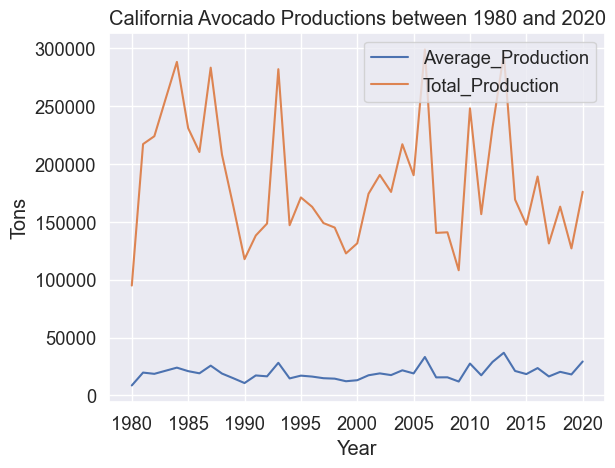

In [22]:
# Line plots of time series for Production
sb.set(font_scale=1.2)
grouped_df[['Average_Production','Total_Production']].plot()
plt.title('California Avocado Productions between 1980 and 2020')
plt.ylabel('Tons')
plt.show()

<Figure size 800x1000 with 0 Axes>

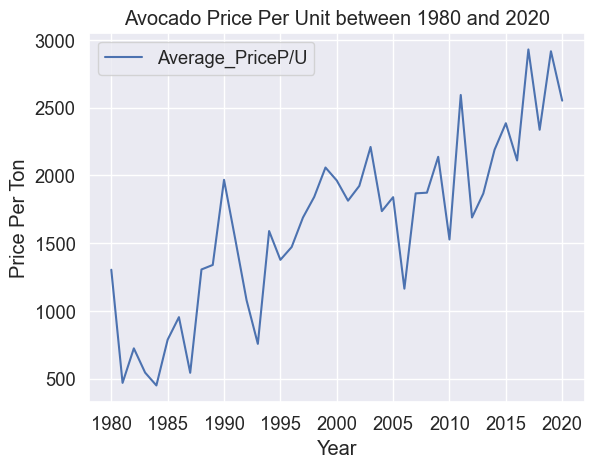

In [23]:
sb.set(font_scale=1.2)
plt.gcf().set_size_inches(8, 10)

# Line plots of time series for Average P/U
grouped_df[['Average_PriceP/U']].plot()
plt.title('Avocado Price Per Unit between 1980 and 2020')
plt.ylabel('Price Per Ton')
plt.show()

## Reading, Merging & Cleaning California Wildfire Data
https://hub-calfire-forestry.hub.arcgis.com/search?categories=cal%20fire%20public%20data&tags=Fire%20and%20Fuels



Counties most vulnerable to wildfires
https://www.sacbee.com/news/california/fires/article261493087.html

In [24]:
#load cali wild fire data set
wildfire = pd.read_csv('Data/California_Wildland_Fire_Perimeters_(All).csv')
wildfire

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape__Area,Shape__Length,COMPLEX_NAME,COMPLEX_INCNUM
0,21440,2020.0,CA,CDF,NEU,NELSON,00013212,2020/06/18 00:00:00+00,2020/06/23 00:00:00+00,11.0,NaN,110.0,109.602280,1.0,1.0,NaN,7.331347e+05,4179.743142,NaN,NaN
1,21441,2020.0,CA,CDF,NEU,AMORUSO,00011799,2020/06/01 00:00:00+00,2020/06/04 00:00:00+00,2.0,NaN,670.0,685.585022,1.0,1.0,NaN,4.578172e+06,12399.375391,NaN,NaN
2,21442,2020.0,CA,CDF,NEU,ATHENS,00018493,2020/08/10 00:00:00+00,2020/03/01 00:00:00+00,14.0,NaN,26.0,27.300480,1.0,1.0,NaN,1.823876e+05,2119.194120,NaN,NaN
3,21443,2020.0,CA,CDF,NEU,FLEMING,00007619,2020/03/31 00:00:00+00,2020/04/01 00:00:00+00,9.0,NaN,13.0,12.931545,1.0,1.0,NaN,8.667942e+04,2029.524881,NaN,NaN
4,21444,2020.0,CA,CDF,NEU,MELANESE,00008471,2020/04/14 00:00:00+00,2020/04/19 00:00:00+00,18.0,NaN,10.3,10.315964,1.0,1.0,NaN,7.017912e+04,1342.742903,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21683,43191,2008.0,CA,USF,SHF,EAST,NaN,NaN,2008/06/29 00:00:00+00,1.0,NaN,NaN,39.796280,7.0,1.0,NaN,2.817346e+05,2009.785182,IRON COMPLEX,00001057
21684,43192,2008.0,CA,USF,SNF,STAR,00000715,2008/06/21 00:00:00+00,2008/07/14 00:00:00+00,1.0,NaN,250.0,267.612793,8.0,1.0,00000018,1.724713e+06,20027.055552,SILVER COMPLEX,00000715
21685,43195,2008.0,CA,CDF,SHU,COLEMAN 1,00001108,NaN,NaN,14.0,NaN,NaN,155.260223,8.0,1.0,NaN,1.084790e+06,4968.611848,NaN,NaN
21686,43196,2008.0,CA,USF,SHF,DEDRICK,NaN,NaN,2008/06/29 00:00:00+00,1.0,NaN,NaN,38.873161,7.0,1.0,NaN,2.751917e+05,2484.561959,IRON COMPLEX,00001057


In [25]:
#keep only relevent columns
wildfire = wildfire[['YEAR_', 'FIRE_NAME']]
wildfire = wildfire.rename(columns={"YEAR_": "Year"})

print(wildfire.dtypes)

Year         float64
FIRE_NAME     object
dtype: object


In [26]:
#check null values
print(wildfire.isnull().sum())

wildfire = wildfire.dropna(subset= ["Year"], axis=0)

Year          77
FIRE_NAME    124
dtype: int64


In [27]:
# perform groupby for each year
wildfire_grouped_df = wildfire.groupby(['Year']).agg({"FIRE_NAME": 'count'})
wildfire_grouped_df.columns = ['Fire_Count']
wildfire_grouped_df = wildfire_grouped_df.reset_index()
wildfire_grouped_df = wildfire_grouped_df.loc[(wildfire_grouped_df['Year'] > 1979.0) & (wildfire_grouped_df['Year'] < 2021.0) ]
print(wildfire_grouped_df)
print(wildfire_grouped_df.dtypes)

       Year  Fire_Count
82   1980.0         313
83   1981.0         271
84   1982.0         145
85   1983.0         159
86   1984.0         217
87   1985.0         209
88   1986.0         172
89   1987.0         286
90   1988.0         257
91   1989.0         181
92   1990.0         175
93   1991.0          89
94   1992.0         197
95   1993.0         172
96   1994.0         217
97   1995.0         208
98   1996.0         319
99   1997.0         187
100  1998.0         163
101  1999.0         279
102  2000.0         192
103  2001.0         207
104  2002.0         243
105  2003.0         341
106  2004.0         277
107  2005.0         306
108  2006.0         316
109  2007.0         347
110  2008.0         440
111  2009.0         254
112  2010.0         209
113  2011.0         316
114  2012.0         352
115  2013.0         298
116  2014.0         238
117  2015.0         309
118  2016.0         349
119  2017.0         607
120  2018.0         410
121  2019.0         312
122  2020.0     

In [28]:
# Adjust data type for Year
wildfire_grouped_df['Year']=wildfire_grouped_df['Year'].astype('int64',errors='raise')

adf=adf.merge(wildfire_grouped_df, on='Year', how='left') 
print(adf.head())

   Year  CountyCode           County  HarvestedAcres  Yield  Production  \
0  2020          53         Monterey           223.0   5.56      1240.0   
1  2020          71   San Bernardino           370.0   2.16       799.0   
2  2020          73        San Diego         14400.0   3.51     50500.0   
3  2020          79  San Luis Obispo          4240.0   5.90     25000.0   
4  2020          83    Santa Barbara          5770.0   4.89     28200.0   

   PriceP/U        Value  Fire_Count  
0   2379.84    2951000.0         499  
1   2617.02    2091000.0         499  
2   3028.87  152958000.0         499  
3   1886.76   47169000.0         499  
4   2842.59   80161000.0         499  


In [29]:
print(adf.dtypes)

Year                int64
CountyCode          int64
County             object
HarvestedAcres    float64
Yield             float64
Production        float64
PriceP/U          float64
Value             float64
Fire_Count          int64
dtype: object


/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_12757/1423695156.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


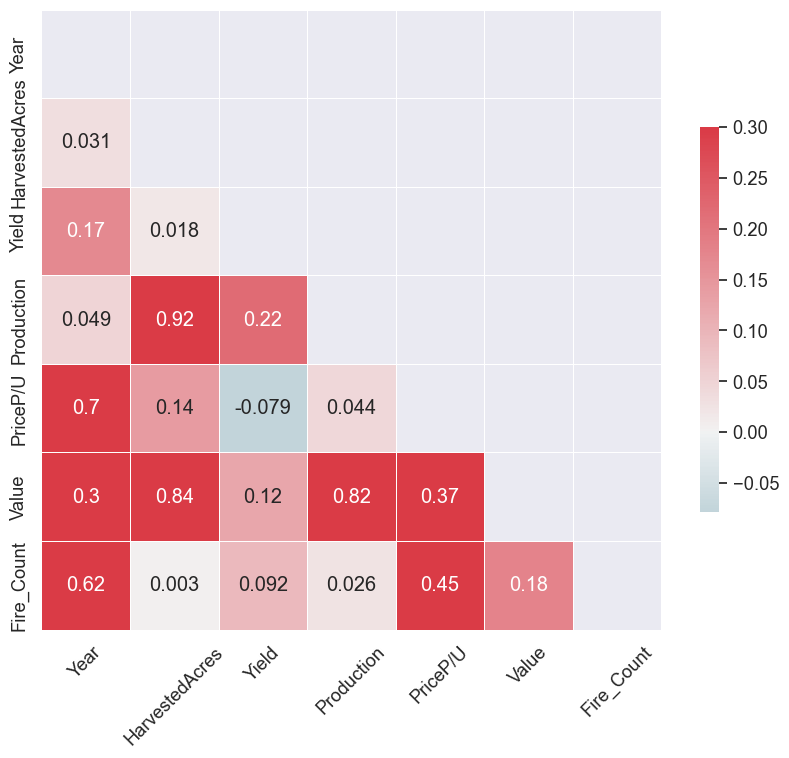

In [30]:
# Review the correlation graph
numeric_df = adf.drop(['CountyCode', 'County'], axis=1)
numeric_df['Year'] = numeric_df['Year'].astype(int)
corr = numeric_df.corr()
#print(corr)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=[10,10])
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.xticks(rotation = 45)
plt.show()

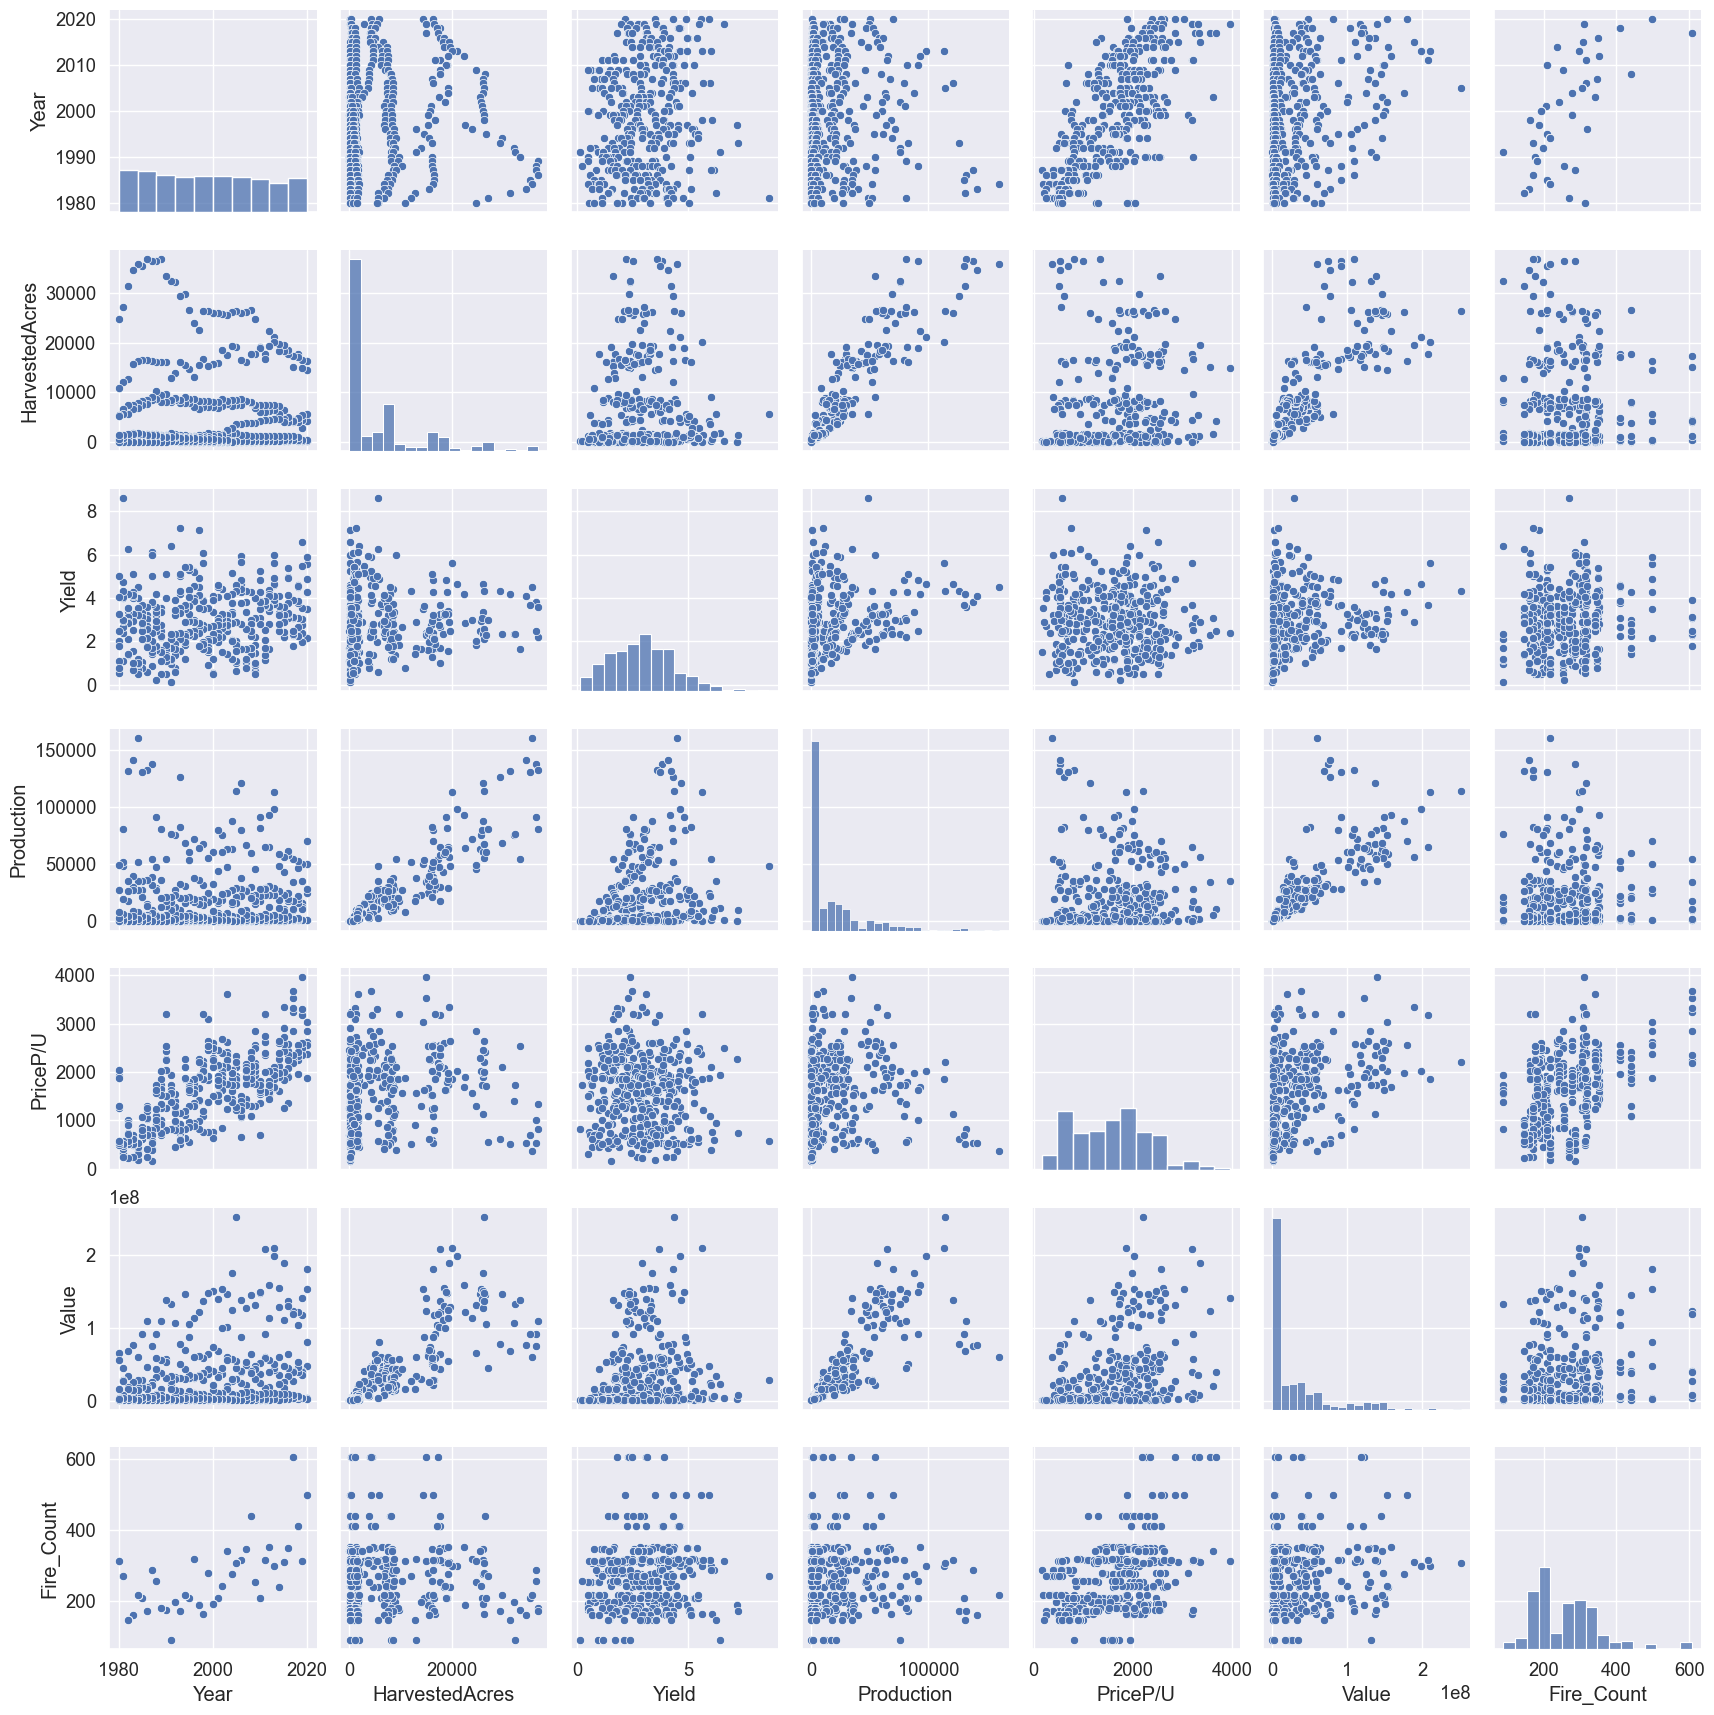

In [31]:
#Create pairplot for numeric_df
sb.pairplot(numeric_df)
plt.show()

# Analysis

## Time Series Analysis Using ARIMA
### Analyzing California Avocado Prices and Productions

#### Forecasting Average Avocado Prices in California

In [32]:
#get a copy of the average price per unit data to make predictions
grouped_df_model1 = grouped_df[['Average_PriceP/U']]

In [33]:
#convert price per ton to price per pound
grouped_df_model1['AvgPricePerPound'] = grouped_df_model1['Average_PriceP/U'] / 2000
grouped_df_model1

/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_12757/649706982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_model1['AvgPricePerPound'] = grouped_df_model1['Average_PriceP/U'] / 2000


,Average_PriceP/U,AvgPricePerPound
Year,,
1980,1304.454545,0.652227
1981,469.818182,0.234909
1982,724.500000,0.362250
1983,545.583333,0.272792
1984,450.833333,0.225417
1985,788.545455,0.394273
1986,954.727273,0.477364
1987,544.272727,0.272136
1988,1306.454545,0.653227


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


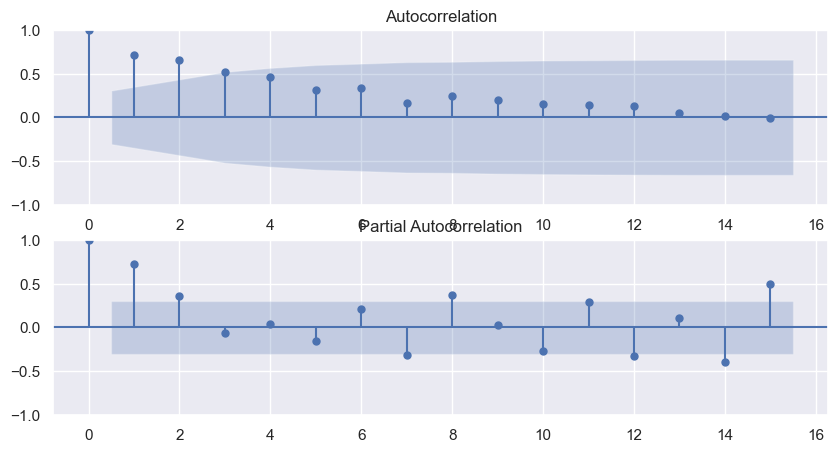

In [34]:
#create ACF and PACF plots to review the data
sb.set(font_scale=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(grouped_df_model1['AvgPricePerPound'], lags=15, ax=ax1)
ax2 = plot_pacf(grouped_df_model1['AvgPricePerPound'], lags=15, ax=ax2)
plt.show()

In [35]:
# Check stationarity
result = adfuller(grouped_df_model1['AvgPricePerPound'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.152035
p-value: 0.693881
Critical Test Statistics Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In [36]:
# Differencing
time_series_diff = grouped_df_model1['AvgPricePerPound'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.739859
p-value: 0.003586
Critical Test Statistics Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


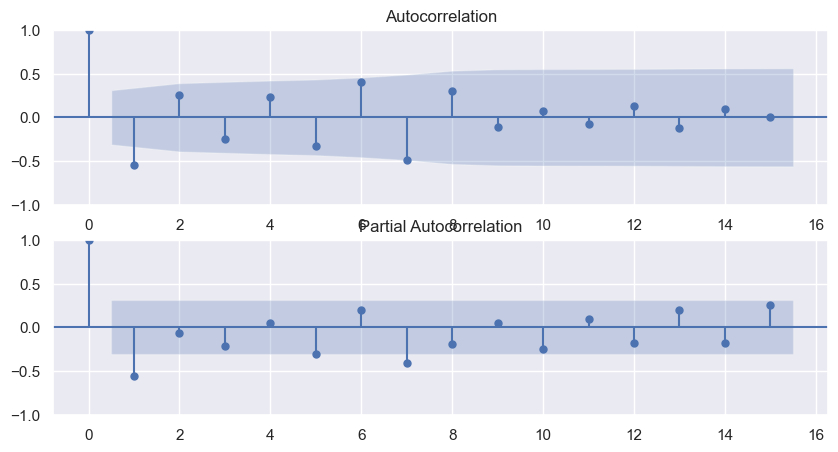

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [38]:
#Referenced code from MILLER (2015) 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = grouped_df_model1['AvgPricePerPound']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# predict 2021 and 2022 values and attach results to end of predictions variable
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)


>Predicted=1.172, Expected=  1
>Predicted=1.149, Expected=  1
>Predicted=1.282, Expected=  1
>Predicted=1.365, Expected=  1
>Predicted=1.328, Expected=  1
RMSE: 0.166


In [39]:
#create a DF that includes both original and predicted results
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_CA1 = pd.DataFrame()
predictionDf_CA1['Year'] = list(range(1980, 2023))
predictionDf_CA1 = predictionDf_CA1.set_index('Year')
predictionDf_CA1['ForecastResult'] = ForecastResult
predictionDf_CA1['PricePerPound'] = list(X) + [None]*2

#check results
print(predictionDf_CA1.tail())

      ForecastResult  PricePerPound
Year                               
2018        1.281741       1.168522
2019        1.364683       1.458060
2020        1.328101       1.275971
2021        1.414864            NaN
2022        1.368588            NaN


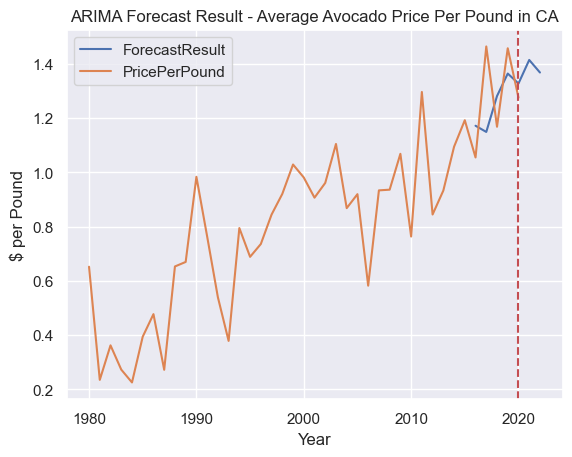

In [40]:
#plot data
predictionDf_CA1.plot()
plt.title('ARIMA Forecast Result - Average Avocado Price Per Pound in CA')
plt.axvline(x=2020, ls = '--', c='r')
plt.ylabel('$ per Pound')
plt.savefig('Forecast_CA_Price.png')

#### Forecasting Average Avocado Production in California

In [41]:
#get a copy of the average price per unit data to make predictions
grouped_df_model2 = grouped_df[['Total_Production']]
grouped_df_model2

,Total_Production
Year,
1980,94992.0
1981,217254.0
1982,224058.0
1983,256303.0
1984,288289.0
1985,231040.0
1986,210412.0
1987,283313.0
1988,208111.0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


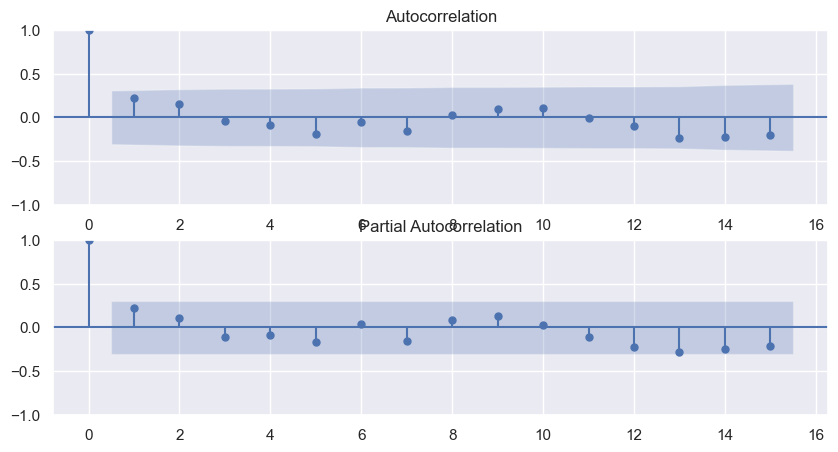

In [42]:
#create ACF and PACF plots
sb.set(font_scale=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(grouped_df_model2, lags=15, ax=ax1)
ax2 = plot_pacf(grouped_df_model2, lags=15, ax=ax2)
plt.show()

In [43]:
# Check stationarity: results suggest data is stationary 
result = adfuller(grouped_df_model2,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.116521
p-value: 0.000013
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


RMSE: 33510.202


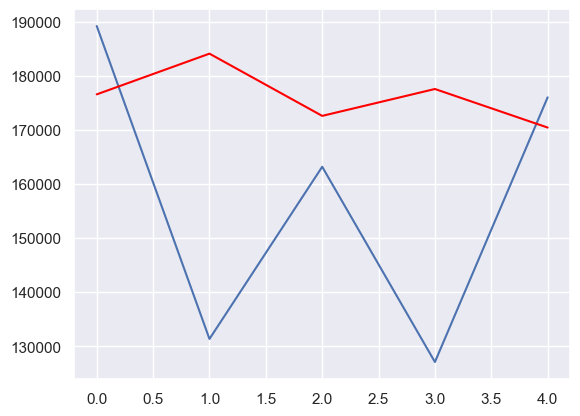

In [44]:
# load data
series = grouped_df_model2
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]

#make predictions
model = ARIMA(grouped_df_model2.values,order=(1,0,1))
model_fit=model.fit()
predictions = model_fit.predict(start = 36, end= 42, dynamic= False)

# report performance
predictions_for_eval = predictions[:-2]
mse = mean_squared_error(test, predictions_for_eval)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions_for_eval, color='red')
plt.show()


In [45]:
#make predictions 
model = ARIMA(grouped_df_model2.values,order=(1,0,1))
model_fit=model.fit()
predictions = model_fit.predict(start = 36, end= 42, dynamic= False)
print(predictions)

[176586.2950086  184116.99870919 172605.9536854  177578.72756663
 170448.18185576 180043.69772342 182707.60529689]


In [46]:
ForecastResult = [None]*(len(grouped_df_model2.values)-5)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_CA2 = pd.DataFrame()
predictionDf_CA2['Year'] = list(range(1980, 2023))
predictionDf_CA2 = predictionDf_CA2.set_index('Year')
predictionDf_CA2['ForecastResult'] = ForecastResult
predictionDf_CA2['Production'] = list(grouped_df_model2['Total_Production']) + [None]*2

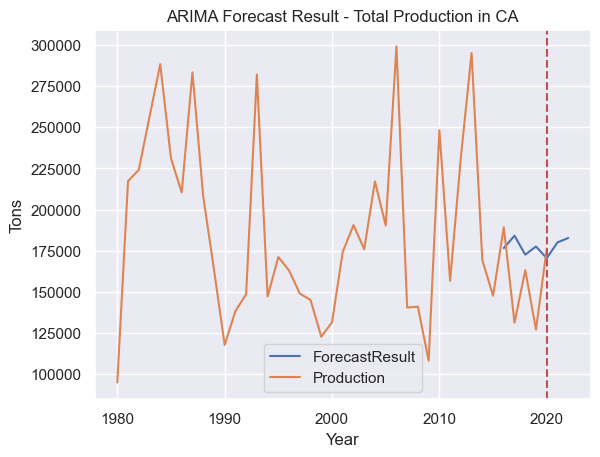

In [47]:
predictionDf_CA2.plot()
plt.title('ARIMA Forecast Result - Total Production in CA')
plt.axvline(x=2020, ls = '--', c='r')
plt.ylabel('Tons')
plt.savefig('Forecast_CA_Production.png')

The ARIMA results indicate that avocado total production in California will continue to grow in 2021 and 2022, but its long way from past production highs is reason for concern.

### ARIMA: Forecasting Avocado Production in California by County

In [48]:
#prepare data for time series analysis graph
model_data1 = adf[['Year','County','Production','PriceP/U']]
model_data1 = model_data1.sort_values('Year')

In [49]:
#Create time series plot for counties that have productions every year
model_data1_TS = model_data1[model_data1['County'] == 'San Bernardino'][['Year']]
model_data1_TS['San Bernardino'] = model_data1[model_data1['County'] == 'San Bernardino'][['Production']]
model_data1_TS = model_data1_TS.reset_index(drop=True)
model_data1_TS['San Diego'] = model_data1[model_data1['County'] == 'San Diego'][['Production']].reset_index(drop=True)
model_data1_TS['San Luis Obispo'] = model_data1[model_data1['County'] == 'San Luis Obispo'][['Production']].reset_index(drop=True)
model_data1_TS['Santa Barbara'] = model_data1[model_data1['County'] == 'Santa Barbara'][['Production']].reset_index(drop=True)
model_data1_TS['Ventura'] = model_data1[model_data1['County'] == 'Ventura'][['Production']].reset_index(drop=True)

#set Year column as index
model_data1_TS = model_data1_TS.set_index('Year')
print(model_data1_TS)

      San Bernardino  San Diego  San Luis Obispo  Santa Barbara   Ventura
Year                                                                     
1980           487.0    49640.0            398.0        27050.0    8440.0
1981           420.0    81150.0            933.0        48418.0   52151.0
1982           320.0   131554.0           1197.0        35325.0   17847.0
1983           516.0   141450.0           1036.0        27670.0   39778.0
1984           510.0   160574.0           1812.0        27521.0   52070.0
1985           405.0   130795.0           3808.0        20906.0   35079.0
1986           510.0   132480.0           3471.0        13159.0   35855.0
1987           300.0   138168.0           2210.0        54786.0   38564.0
1988           338.0    91025.0           2346.0        27338.0   47257.0
1989           322.0    80942.0           4646.0        20739.0   36180.0
1990           840.0    54200.0           1671.0        17586.0   21084.0
1991            29.0    76254.0       

<Figure size 1000x1500 with 0 Axes>

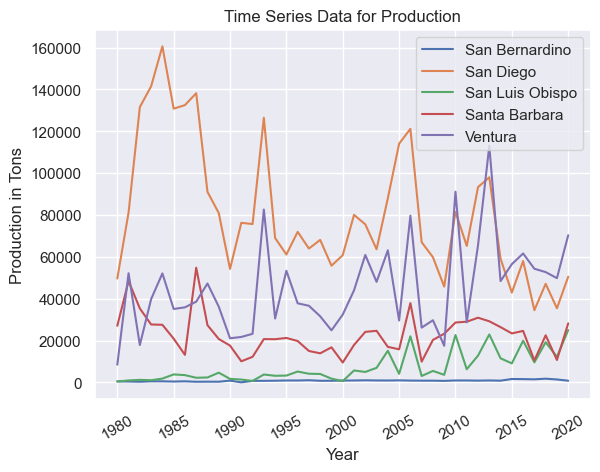

In [50]:
# Line plots of time series
sb.set(font_scale=1)
plt.gcf().set_size_inches(10, 15)

model_data1_TS.plot()
plt.title('Time Series Data for Production')
plt.ylabel('Production in Tons')
plt.xticks(rotation = 30)
plt.show()

#### Build Model for Each County

In [51]:
#### San Bernadino County

In [52]:
sb_df = model_data1[model_data1['County'] == 'San Bernardino']
sb_df1 = sb_df[['Year','Production']]
print(sb_df1)

     Year  Production
388  1980       487.0
377  1981       420.0
365  1982       320.0
353  1983       516.0
341  1984       510.0
329  1985       405.0
318  1986       510.0
307  1987       300.0
296  1988       338.0
285  1989       322.0
274  1990       840.0
265  1991        29.0
256  1992       726.0
247  1993       742.0
237  1994       798.0
227  1995       909.0
217  1996       899.0
207  1997      1020.0
197  1998       765.0
187  1999       771.0
177  2000       860.0
167  2001       904.0
157  2002       990.0
147  2003       917.0
137  2004       895.0
127  2005       966.0
117  2006       860.0
108  2007       820.0
99   2008       817.0
90   2009       720.0
81   2010       915.0
72   2011       912.0
63   2012       840.0
55   2013       917.0
47   2014       822.0
39   2015      1620.0
31   2016      1560.0
23   2017      1470.0
15   2018      1760.0
8    2019      1400.0
1    2020       799.0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


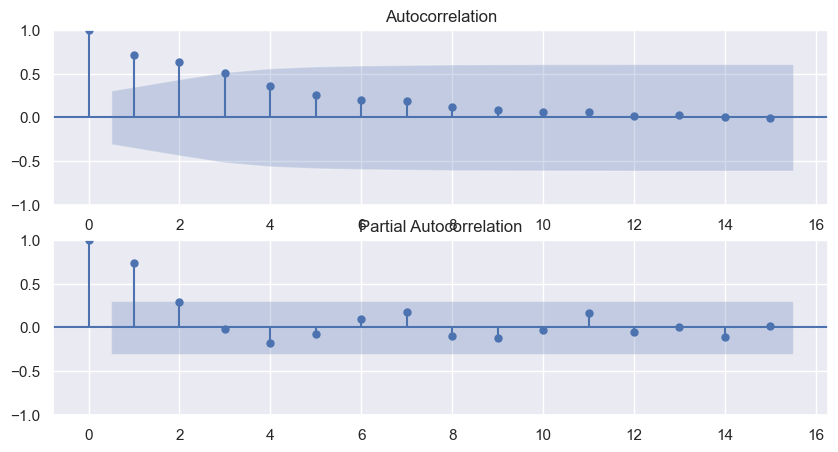

In [53]:
#create ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sb_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sb_df1['Production'], lags=15, ax=ax2)
plt.show()

In [54]:
# Check stationary
result = adfuller(sb_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.765086
p-value: 0.397928
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


In [55]:
# Differencing
time_series_diff = sb_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.000762
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


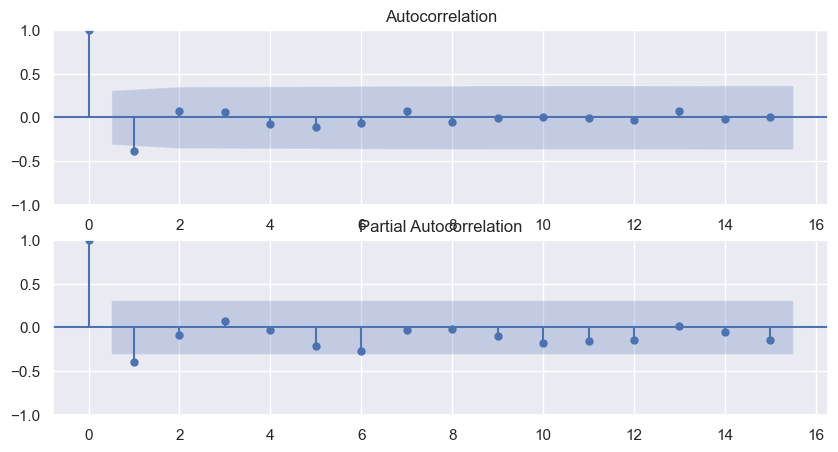

In [56]:
#create ACF and PACF plots again
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [57]:
# load data
series = sb_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=1447.841, Expected=1560
>Predicted=2033.460, Expected=1470
>Predicted=1901.502, Expected=1760
>Predicted=1645.442, Expected=1400
>Predicted=1565.827, Expected=799
RMSE: 446.846


In [58]:
#save prediction and original data in one dataframe
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_sb1 = pd.DataFrame()
predictionDf_sb1['Year'] = list(range(1980, 2023))
predictionDf_sb1 = predictionDf_sb1.set_index('Year')
predictionDf_sb1['ForecastResult'] = ForecastResult
predictionDf_sb1['Production'] = list(X) + [None]*2
print(predictionDf_sb1.tail())

      ForecastResult  Production
Year                            
2018     1901.501887      1760.0
2019     1645.441612      1400.0
2020     1565.827318       799.0
2021     1067.965977         NaN
2022      973.843901         NaN


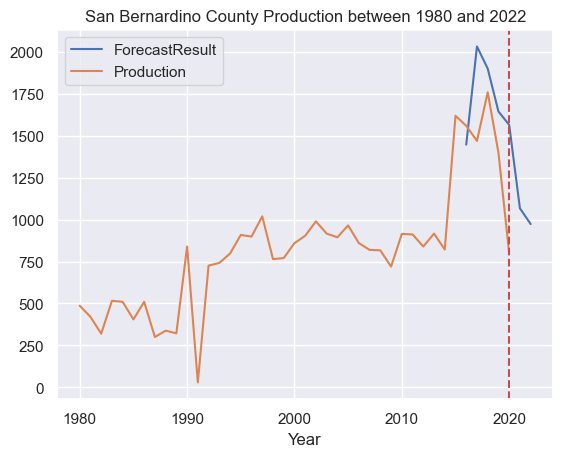

In [59]:
predictionDf_sb1.plot()
plt.title('San Bernardino County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [60]:
#### San Diego County

In [61]:
sd_df = model_data1[model_data1['County'] == 'San Diego']
sd_df1 = sd_df[['Year','Production']]
print(sd_df1)

     Year  Production
389  1980     49640.0
378  1981     81150.0
366  1982    131554.0
354  1983    141450.0
342  1984    160574.0
330  1985    130795.0
319  1986    132480.0
308  1987    138168.0
297  1988     91025.0
286  1989     80942.0
275  1990     54200.0
266  1991     76254.0
257  1992     75655.0
248  1993    126451.0
238  1994     68997.0
228  1995     61094.0
218  1996     71929.0
208  1997     63945.0
198  1998     68081.0
188  1999     55752.0
178  2000     60788.0
168  2001     80032.0
158  2002     75515.0
148  2003     63606.0
138  2004     87987.0
128  2005    114047.0
118  2006    121150.0
109  2007     67002.0
100  2008     59805.0
91   2009     45779.0
82   2010     81500.0
73   2011     65200.0
64   2012     93300.0
56   2013     98000.0
48   2014     59100.0
40   2015     42900.0
32   2016     58000.0
24   2017     34500.0
16   2018     47100.0
9    2019     35400.0
2    2020     50500.0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


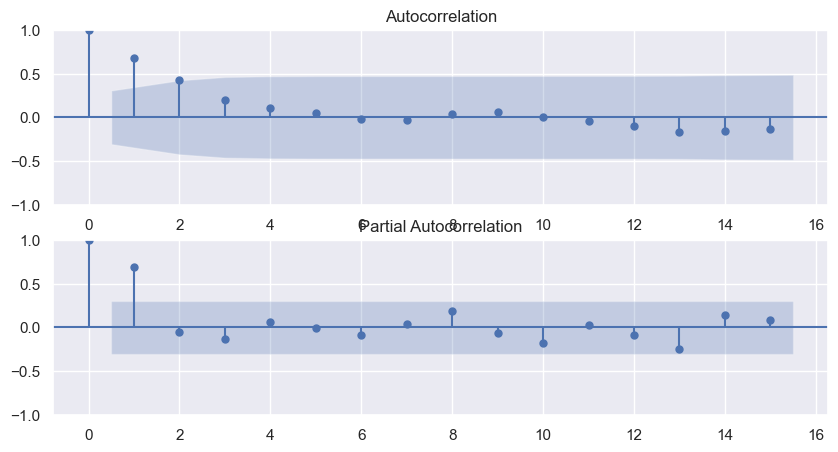

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sd_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sd_df1['Production'], lags=15, ax=ax2)
plt.show()

In [63]:
# Check stationary
result = adfuller(sd_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.654728
p-value: 0.082205
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [64]:
# Differencing
time_series_diff = sd_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.963076
p-value: 0.000026
Critical Test Statistics Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


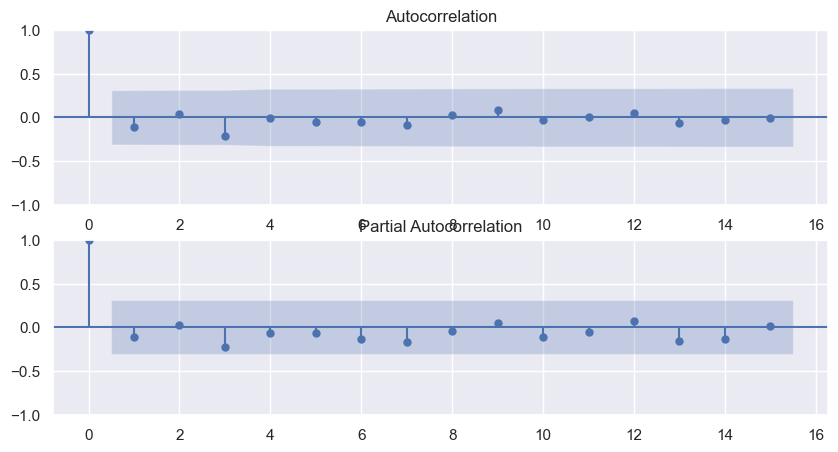

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [66]:

# load data
series = sd_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=42717.410, Expected=58000
>Predicted=57100.373, Expected=34500
>Predicted=34979.585, Expected=47100
>Predicted=45598.264, Expected=35400
>Predicted=35413.859, Expected=50500
RMSE: 15638.639


In [67]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_sd1 = pd.DataFrame()
predictionDf_sd1['Year'] = list(range(1980, 2023))
predictionDf_sd1 = predictionDf_sd1.set_index('Year')
predictionDf_sd1['ForecastResult'] = ForecastResult
predictionDf_sd1['Production'] = list(X) + [None]*2
print(predictionDf_sd1.tail())

      ForecastResult  Production
Year                            
2018    34979.584983     47100.0
2019    45598.263825     35400.0
2020    35413.859312     50500.0
2021    49142.431980         NaN
2022    48976.618769         NaN


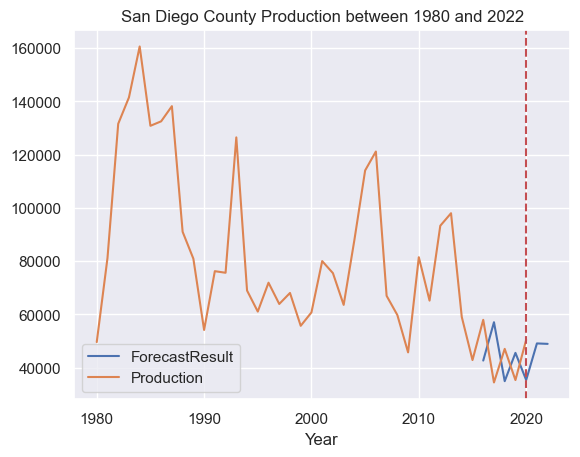

In [68]:
predictionDf_sd1.plot()
plt.title('San Diego County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [69]:
#### Ventura County

In [70]:
v_df = model_data1[model_data1['County'] == 'Ventura']
v_df1 = v_df[['Year','Production']]
print(v_df1)

     Year  Production
393  1980      8440.0
382  1981     52151.0
371  1982     17847.0
359  1983     39778.0
347  1984     52070.0
335  1985     35079.0
324  1986     35855.0
313  1987     38564.0
302  1988     47257.0
291  1989     36180.0
280  1990     21084.0
269  1991     21702.0
261  1992     23214.0
252  1993     82600.0
242  1994     30523.0
232  1995     53334.0
222  1996     37781.0
212  1997     36603.0
202  1998     31565.0
192  1999     24871.0
182  2000     32396.0
172  2001     43973.0
162  2002     60894.0
152  2003     48024.0
141  2004     63095.0
131  2005     29592.0
121  2006     79646.0
112  2007     26160.0
103  2008     29701.0
94   2009     17483.0
85   2010     91100.0
76   2011     28700.0
67   2012     65500.0
59   2013    113000.0
51   2014     48400.0
43   2015     56500.0
35   2016     61600.0
27   2017     54300.0
19   2018     52700.0
12   2019     49800.0
5    2020     70300.0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


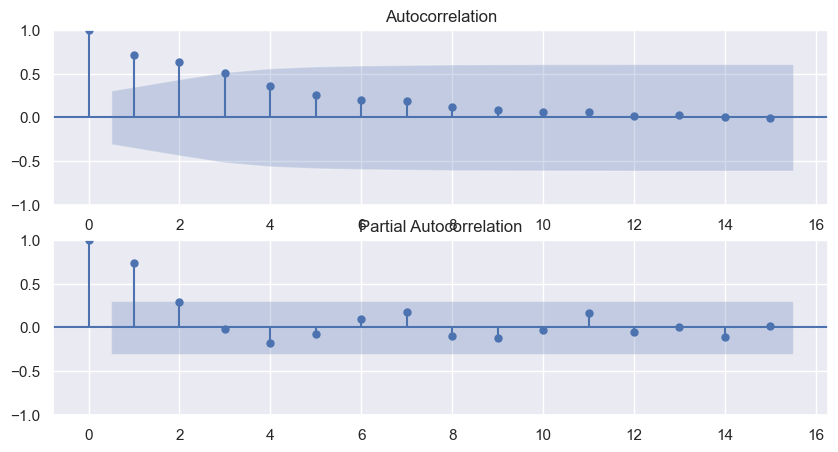

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sb_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sb_df1['Production'], lags=15, ax=ax2)
plt.show()

In [72]:
# Check stationary
result = adfuller(v_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.786268
p-value: 0.998321
Critical Test Statistics Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


In [73]:
# Differencing
time_series_diff = v_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.484031
p-value: 0.000210
Critical Test Statistics Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


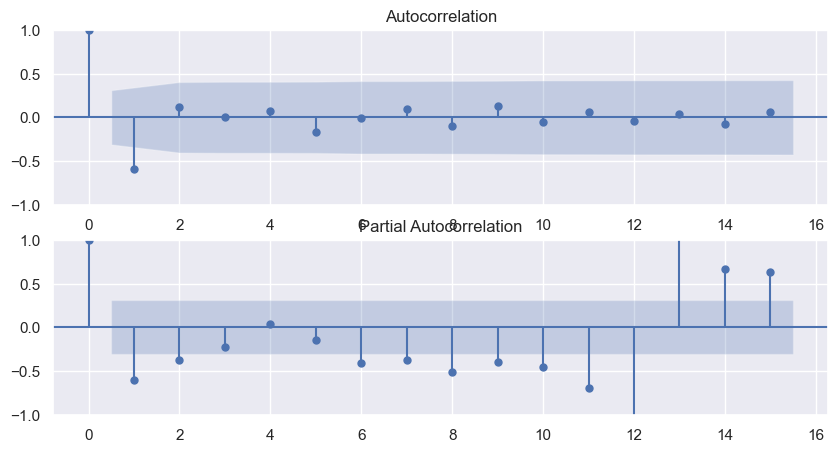

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [75]:
# load data
series = v_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=64937.283, Expected=61600
>Predicted=65111.549, Expected=54300
>Predicted=59362.240, Expected=52700
>Predicted=60032.302, Expected=49800


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=60482.394, Expected=70300
RMSE: 8642.892


In [76]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_v1 = pd.DataFrame()
predictionDf_v1['Year'] = list(range(1980, 2023))
predictionDf_v1 = predictionDf_v1.set_index('Year')
predictionDf_v1['ForecastResult'] = ForecastResult
predictionDf_v1['Production'] = list(X) + [None]*2
print(predictionDf_v1.tail())

      ForecastResult  Production
Year                            
2018    59362.239864     52700.0
2019    60032.301554     49800.0
2020    60482.393869     70300.0
2021    64048.164595         NaN
2022    63044.192797         NaN


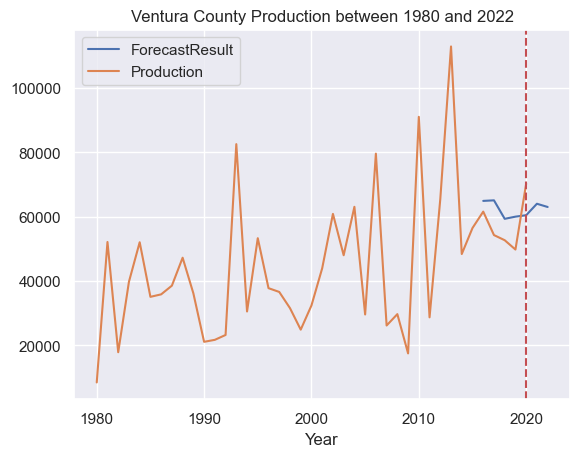

In [77]:
predictionDf_v1.plot()
plt.title('Ventura County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [78]:
#### Santa Barbara County

In [79]:
sbe_df = model_data1[model_data1['County'] == 'Santa Barbara']
sbe_df1 = sbe_df[['Year','Production']]
print(sbe_df1)

     Year  Production
391  1980     27050.0
380  1981     48418.0
368  1982     35325.0
356  1983     27670.0
344  1984     27521.0
332  1985     20906.0
321  1986     13159.0
310  1987     54786.0
299  1988     27338.0
288  1989     20739.0
277  1990     17586.0
268  1991     10078.0
259  1992     12211.0
250  1993     20687.0
240  1994     20629.0
230  1995     21228.0
220  1996     19771.0
210  1997     15002.0
200  1998     13888.0
190  1999     16746.0
180  2000      9496.0
170  2001     17884.0
160  2002     24136.0
150  2003     24638.0
140  2004     16970.0
130  2005     15801.0
120  2006     37871.0
111  2007      9910.0
102  2008     20290.0
93   2009     23236.0
84   2010     28600.0
75   2011     29000.0
66   2012     30900.0
58   2013     29200.0
50   2014     26400.0
42   2015     23400.0
34   2016     24600.0
26   2017     10500.0
18   2018     22500.0
11   2019     10700.0
4    2020     28200.0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


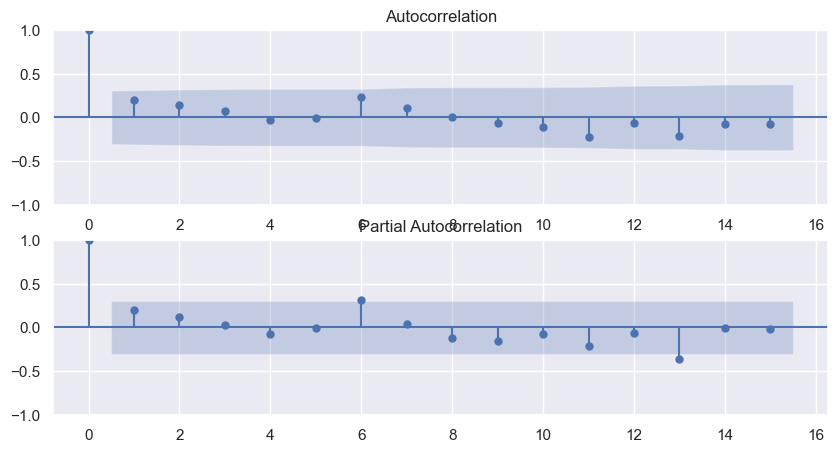

In [80]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sbe_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sbe_df1['Production'], lags=15, ax=ax2)
plt.show()

In [81]:
# Check stationary
result = adfuller(sbe_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.034193
p-value: 0.000019
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [82]:
# load data
series = sbe_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=24510.220, Expected=24600
>Predicted=24000.480, Expected=10500
>Predicted=15727.630, Expected=22500
>Predicted=17078.945, Expected=10700
>Predicted=15452.770, Expected=28200
RMSE: 9287.829


In [83]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_sbe1 = pd.DataFrame()
predictionDf_sbe1['Year'] = list(range(1980, 2023))
predictionDf_sbe1 = predictionDf_sbe1.set_index('Year')
predictionDf_sbe1['ForecastResult'] = ForecastResult
predictionDf_sbe1['Production'] = list(X) + [None]*2
print(predictionDf_sbe1.tail())

      ForecastResult  Production
Year                            
2018    15727.629776     22500.0
2019    17078.945242     10700.0
2020    15452.769584     28200.0
2021    19841.623900         NaN
2022    23593.640524         NaN


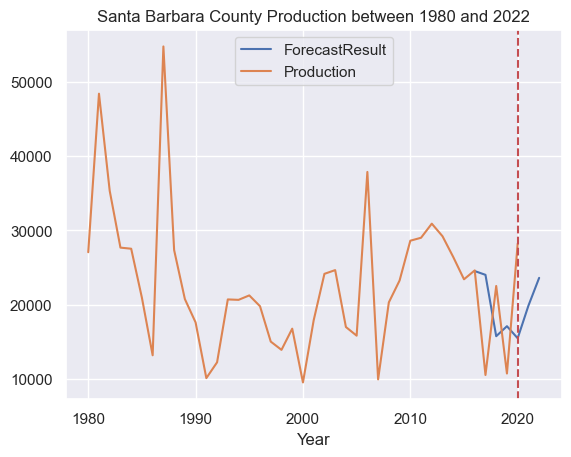

In [84]:
predictionDf_sbe1.plot()
plt.title('Santa Barbara County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [85]:
#### San Luis Obispo County

In [86]:
slo_df = model_data1[model_data1['County'] == 'San Luis Obispo']
slo_df1 = slo_df[['Year','Production']]
print(slo_df1)

     Year  Production
390  1980       398.0
379  1981       933.0
367  1982      1197.0
355  1983      1036.0
343  1984      1812.0
331  1985      3808.0
320  1986      3471.0
309  1987      2210.0
298  1988      2346.0
287  1989      4646.0
276  1990      1671.0
267  1991      1351.0
258  1992       699.0
249  1993      3768.0
239  1994      3156.0
229  1995      3254.0
219  1996      5181.0
209  1997      4133.0
199  1998      4013.0
189  1999      1791.0
179  2000       613.0
169  2001      5689.0
159  2002      4992.0
149  2003      6949.0
139  2004     15111.0
129  2005      4079.0
119  2006     22008.0
110  2007      3056.0
101  2008      5474.0
92   2009      3613.0
83   2010     22640.0
74   2011      6280.0
65   2012     12800.0
57   2013     22900.0
49   2014     11500.0
41   2015      9070.0
33   2016     19900.0
25   2017      9570.0
17   2018     19200.0
10   2019     12200.0
3    2020     25000.0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


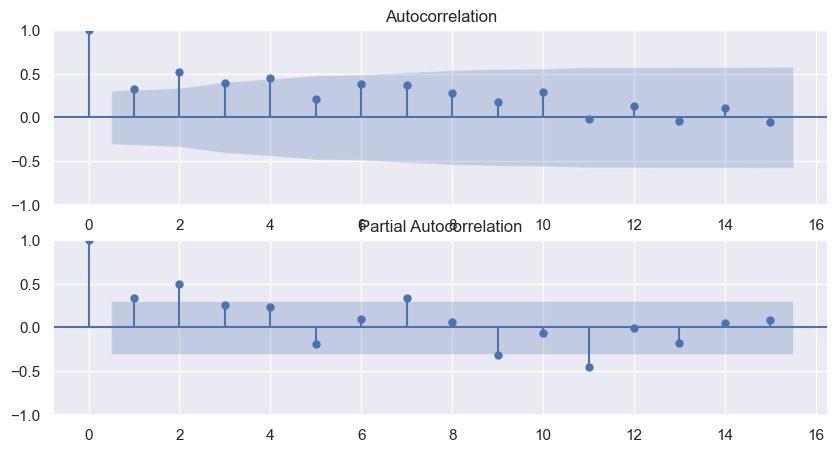

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(slo_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(slo_df1['Production'], lags=15, ax=ax2)
plt.show()

In [88]:
# Check stationary
result = adfuller(slo_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.110574
p-value: 0.995306
Critical Test Statistics Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In [89]:
# Differencing
time_series_diff = slo_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.533715
p-value: 0.516772
Critical Test Statistics Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


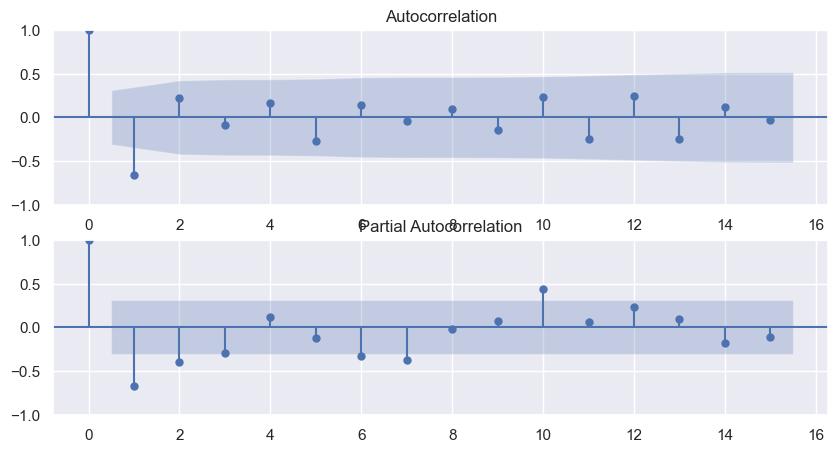

In [90]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [91]:
# load data
series = slo_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=17056.733, Expected=19900
>Predicted=12061.253, Expected=9570
>Predicted=16534.791, Expected=19200


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=15435.066, Expected=12200
>Predicted=17319.807, Expected=25000
RMSE: 4262.508


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [92]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_slo1 = pd.DataFrame()
predictionDf_slo1['Year'] = list(range(1980, 2023))
predictionDf_slo1 = predictionDf_slo1.set_index('Year')
predictionDf_slo1['ForecastResult'] = ForecastResult
predictionDf_slo1['Production'] = list(X) + [None]*2
print(predictionDf_slo1.tail())

      ForecastResult  Production
Year                            
2018    16534.790785     19200.0
2019    15435.065896     12200.0
2020    17319.807002     25000.0
2021    12813.740736         NaN
2022    21612.790445         NaN


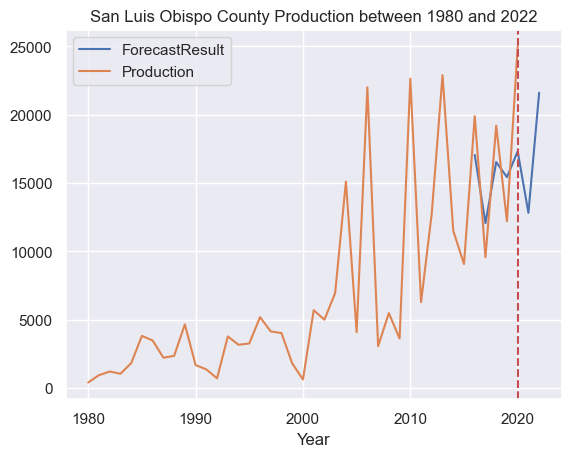

In [93]:
predictionDf_slo1.plot()
plt.title('San Luis Obispo County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

### ARIMA: Forecasting Avocado Prices in California by County

In [94]:
#convert Price Per Ton to Price Per Pound
model_data1['PriceP/U'] = model_data1['PriceP/U']/2000

In [95]:
#prepare data for time series analysis graph
model_data2_TS = model_data1[model_data1['County'] == 'San Bernardino'][['Year']]
model_data2_TS['San Bernardino'] = model_data1[model_data1['County'] == 'San Bernardino'][['PriceP/U']]
model_data2_TS = model_data2_TS.reset_index(drop=True)
model_data2_TS['San Diego'] = model_data1[model_data1['County'] == 'San Diego'][['PriceP/U']].reset_index(drop=True)
model_data2_TS['San Luis Obispo'] = model_data1[model_data1['County'] == 'San Luis Obispo'][['PriceP/U']].reset_index(drop=True)
model_data2_TS['Santa Barbara'] = model_data1[model_data1['County'] == 'Santa Barbara'][['PriceP/U']].reset_index(drop=True)
model_data2_TS['Ventura'] = model_data1[model_data1['County'] == 'Ventura'][['PriceP/U']].reset_index(drop=True)

#set Year column as index
model_data2_TS = model_data2_TS.set_index('Year')
print(model_data2_TS)

      San Bernardino  San Diego  San Luis Obispo  Santa Barbara   Ventura
Year                                                                     
1980        0.264000   0.650000         0.965000       1.025000  0.940500
1981        0.126000   0.276500         0.260000       0.290000  0.260000
1982        0.107500   0.260000         0.465000       0.470000  0.450000
1983        0.121000   0.270000         0.312000       0.270000  0.312000
1984        0.090000   0.185000         0.270000       0.262000  0.271500
1985        0.307500   0.351000         0.425000       0.428500  0.400000
1986        0.123500   0.410000         0.522500       0.596500  0.632000
1987        0.081500   0.270000         0.262500       0.199000  0.271500
1988        0.550500   0.500000         0.805500       0.785500  0.613500
1989        0.369500   0.670000         0.825000       0.924500  0.763000
1990        0.400000   1.274500         1.125500       1.600500  1.265500
1991        0.407500   0.863000       

<Figure size 1000x1500 with 0 Axes>

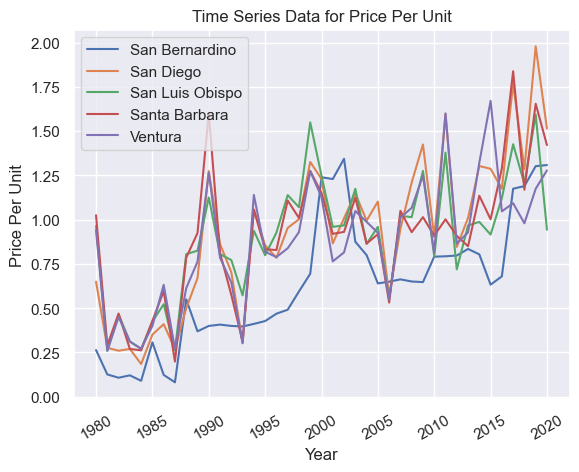

In [96]:
# Line plots of time series
sb.set(font_scale=1)
plt.gcf().set_size_inches(10, 15)

model_data2_TS.plot()
plt.title('Time Series Data for Price Per Unit')
plt.ylabel('Price Per Unit')
plt.xticks(rotation = 30)
plt.show()

In [97]:
### San Bernardino County

In [98]:
sb_df = model_data1[model_data1['County'] == 'San Bernardino']
sb_df2 = sb_df[['Year','PriceP/U']]
print(sb_df2)

     Year  PriceP/U
388  1980  0.264000
377  1981  0.126000
365  1982  0.107500
353  1983  0.121000
341  1984  0.090000
329  1985  0.307500
318  1986  0.123500
307  1987  0.081500
296  1988  0.550500
285  1989  0.369500
274  1990  0.400000
265  1991  0.407500
256  1992  0.400000
247  1993  0.397000
237  1994  0.411500
227  1995  0.427500
217  1996  0.469000
207  1997  0.491500
197  1998  0.594500
187  1999  0.694500
177  2000  1.239500
167  2001  1.229500
157  2002  1.344000
147  2003  0.875410
137  2004  0.800000
127  2005  0.640060
117  2006  0.650000
108  2007  0.662990
99   2008  0.650980
90   2009  0.647500
81   2010  0.791255
72   2011  0.793310
63   2012  0.797620
55   2013  0.834785
47   2014  0.804135
39   2015  0.633025
31   2016  0.680130
23   2017  1.174830
15   2018  1.189775
8    2019  1.302145
1    2020  1.308510


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


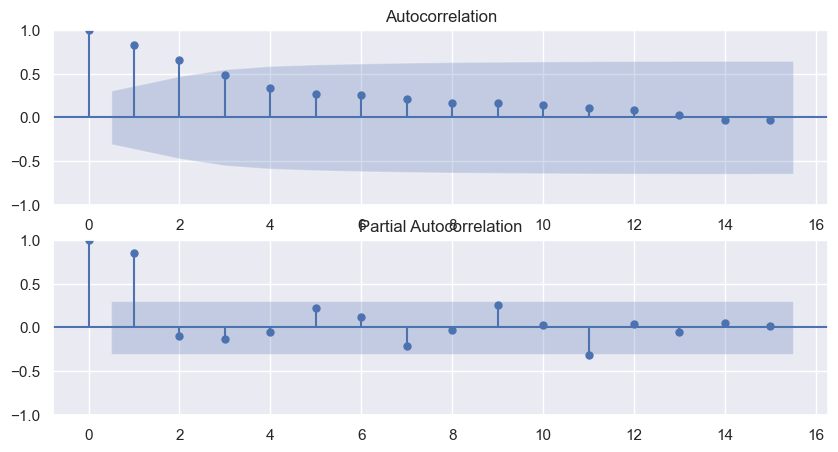

In [99]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sb_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(sb_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [100]:
# Check stationary
result = adfuller(sb_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.152243
p-value: 0.693795
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [101]:
# Differencing
time_series_diff = sb_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.648104
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


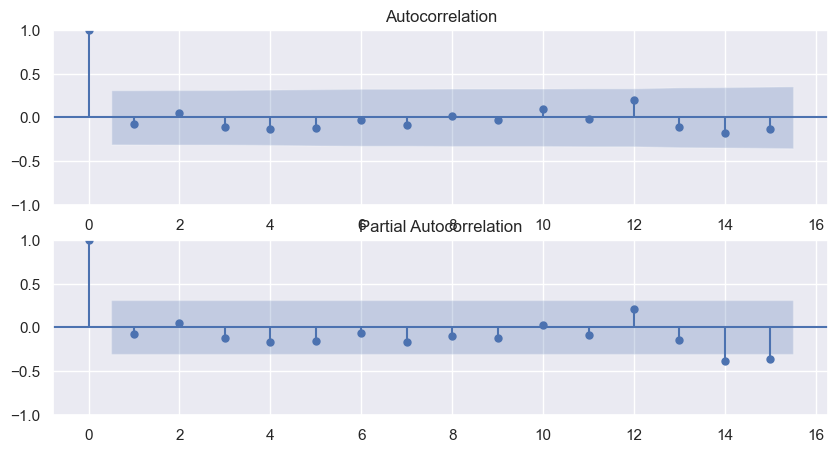

In [102]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [103]:
# load data
series = sb_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

>Predicted=0.657, Expected=  1
>Predicted=0.689, Expected=  1
>Predicted=1.173, Expected=  1
>Predicted=1.215, Expected=  1
>Predicted=1.324, Expected=  1
RMSE: 0.221


In [104]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_sb2 = pd.DataFrame()
predictionDf_sb2['Year'] = list(range(1980, 2023))
predictionDf_sb2 = predictionDf_sb2.set_index('Year')
predictionDf_sb2['ForecastResult'] = ForecastResult
predictionDf_sb2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_sb2.tail())

      ForecastResult  Price/Pound
Year                             
2018        1.172505     1.189775
2019        1.214841     1.302145
2020        1.324434     1.308510
2021        1.335927          NaN
2022        1.362218          NaN


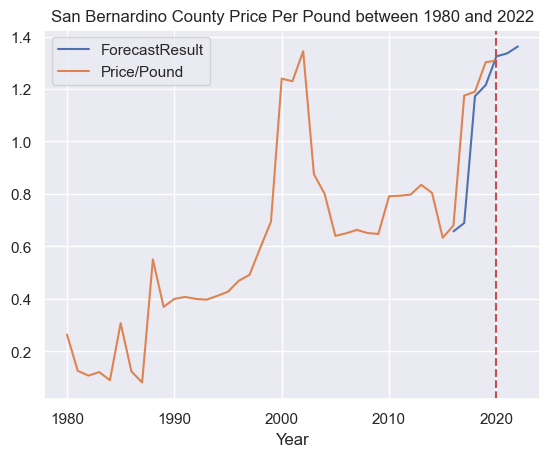

In [105]:
predictionDf_sb2.plot()
plt.title('San Bernardino County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [106]:
### San Diego County

In [107]:
sd_df = model_data1[model_data1['County'] == 'San Diego']
sd_df2 = sd_df[['Year','PriceP/U']]
print(sd_df2)

     Year  PriceP/U
389  1980  0.650000
378  1981  0.276500
366  1982  0.260000
354  1983  0.270000
342  1984  0.185000
330  1985  0.351000
319  1986  0.410000
308  1987  0.270000
297  1988  0.500000
286  1989  0.670000
275  1990  1.274500
266  1991  0.863000
257  1992  0.703000
248  1993  0.304000
238  1994  1.057000
228  1995  0.855500
218  1996  0.784500
208  1997  0.953500
198  1998  1.002500
188  1999  1.326000
178  2000  1.230000
168  2001  0.866000
158  2002  1.008500
148  2003  1.149040
138  2004  0.994500
128  2005  1.102405
118  2006  0.566675
109  2007  0.948475
100  2008  1.209720
91   2009  1.425085
82   2010  0.902160
73   2011  1.596095
64   2012  0.846205
56   2013  1.009770
48   2014  1.303200
40   2015  1.287345
32   2016  1.174360
24   2017  1.770870
16   2018  1.284905
9    2019  1.979040
2    2020  1.514435


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


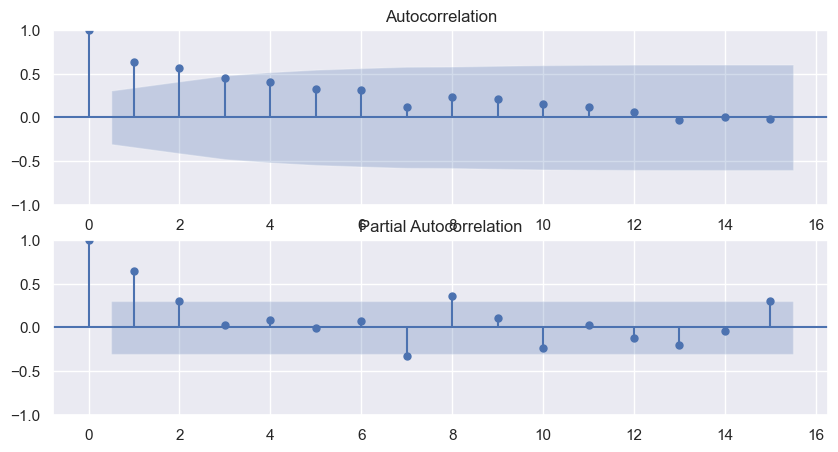

In [108]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sd_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(sd_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [109]:
# Check stationary
result = adfuller(sd_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.479124
p-value: 0.543812
Critical Test Statistics Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


In [110]:
# Differencing
time_series_diff = sd_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.752018
p-value: 0.003438
Critical Test Statistics Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


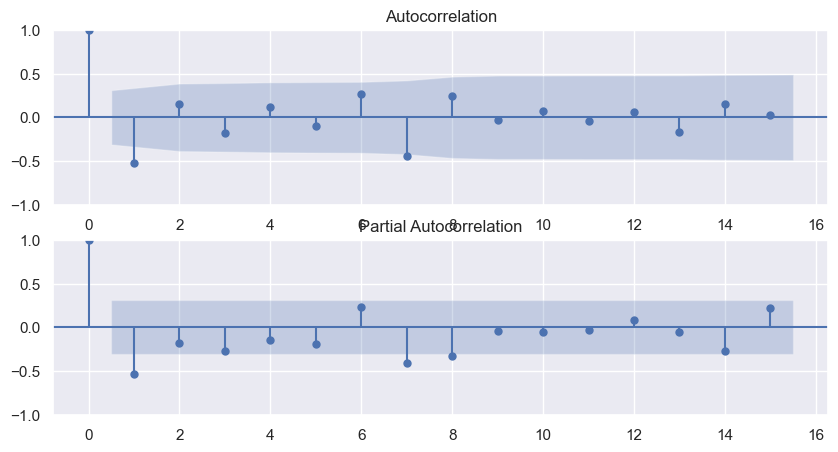

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [112]:
# load data
series = sd_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Predicted=1.312, Expected=  1
>Predicted=1.262, Expected=  2
>Predicted=1.535, Expected=  1
>Predicted=1.582, Expected=  2
>Predicted=1.627, Expected=  2
RMSE: 0.320


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [113]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_sd2 = pd.DataFrame()
predictionDf_sd2['Year'] = list(range(1980, 2023))
predictionDf_sd2 = predictionDf_sd2.set_index('Year')
predictionDf_sd2['ForecastResult'] = ForecastResult
predictionDf_sd2['Price/Unit'] = list(X) + [None]*2
print(predictionDf_sd2.tail())

      ForecastResult  Price/Unit
Year                            
2018        1.535398    1.284905
2019        1.582179    1.979040
2020        1.626793    1.514435
2021        1.872741         NaN
2022        1.646932         NaN


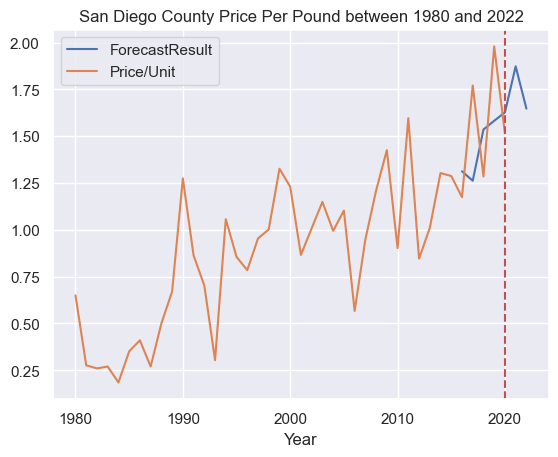

In [114]:
predictionDf_sd2.plot()
plt.title('San Diego County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [115]:
### Ventura County

In [116]:
v_df = model_data1[model_data1['County'] == 'Ventura']
v_df2 = v_df[['Year','PriceP/U']]
print(v_df2)

     Year  PriceP/U
393  1980  0.940500
382  1981  0.260000
371  1982  0.450000
359  1983  0.312000
347  1984  0.271500
335  1985  0.400000
324  1986  0.632000
313  1987  0.271500
302  1988  0.613500
291  1989  0.763000
280  1990  1.265500
269  1991  0.785500
261  1992  0.645000
252  1993  0.302000
242  1994  1.140000
232  1995  0.818500
222  1996  0.789000
212  1997  0.838500
202  1998  0.930000
192  1999  1.273500
182  2000  1.128000
172  2001  0.764500
162  2002  0.815500
152  2003  1.049060
141  2004  0.987890
131  2005  0.925975
121  2006  0.548620
112  2007  1.011295
103  2008  1.066900
94   2009  1.249130
85   2010  0.814175
76   2011  1.600155
67   2012  0.865000
59   2013  0.927980
51   2014  1.322085
43   2015  1.670955
35   2016  1.047080
27   2017  1.092820
19   2018  0.979620
12   2019  1.174510
5    2020  1.278285


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


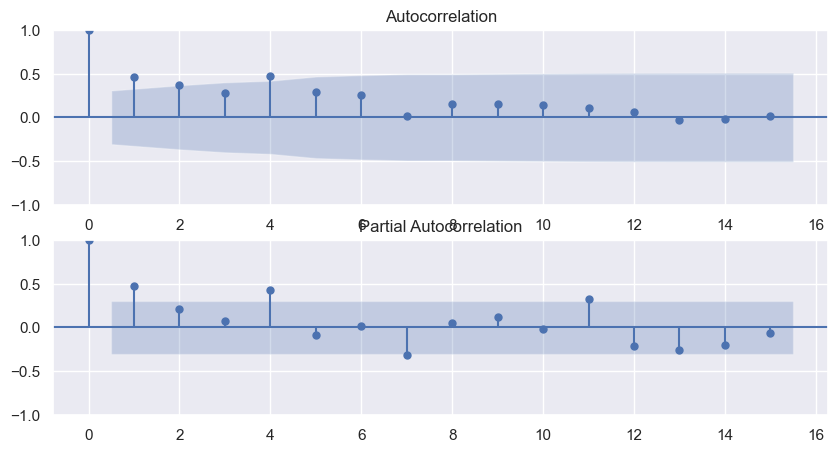

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(v_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(v_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [118]:
# Check stationary
result = adfuller(v_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.456596
p-value: 0.554863
Critical Test Statistics Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [119]:
# Differencing
time_series_diff = v_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.674454
p-value: 0.000094
Critical Test Statistics Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


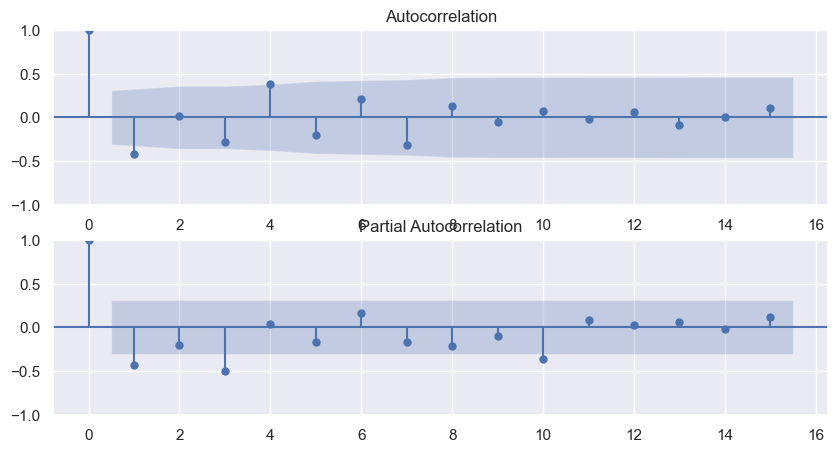

In [120]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [121]:

# load data
series = v_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


>Predicted=1.562, Expected=  1
>Predicted=1.294, Expected=  1
>Predicted=0.921, Expected=  1
>Predicted=1.136, Expected=  1
>Predicted=1.034, Expected=  1
RMSE: 0.272


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [122]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_v2 = pd.DataFrame()
predictionDf_v2['Year'] = list(range(1980, 2023))
predictionDf_v2 = predictionDf_v2.set_index('Year')
predictionDf_v2['ForecastResult'] = ForecastResult
predictionDf_v2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_v2.tail())

      ForecastResult  Price/Pound
Year                             
2018        0.921175     0.979620
2019        1.135595     1.174510
2020        1.033988     1.278285
2021        1.373851          NaN
2022        1.309512          NaN


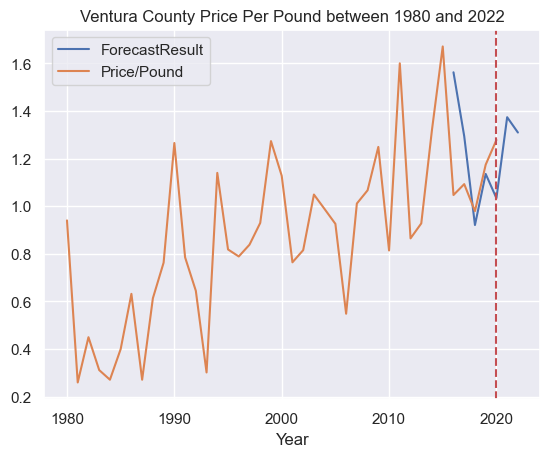

In [123]:
predictionDf_v2.plot()
plt.title('Ventura County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [124]:
### Santa Barbara County

In [125]:
sbe_df = model_data1[model_data1['County'] == 'Santa Barbara']
sbe_df2 = sbe_df[['Year','PriceP/U']]
print(sbe_df2)

     Year  PriceP/U
391  1980  1.025000
380  1981  0.290000
368  1982  0.470000
356  1983  0.270000
344  1984  0.262000
332  1985  0.428500
321  1986  0.596500
310  1987  0.199000
299  1988  0.785500
288  1989  0.924500
277  1990  1.600500
268  1991  0.812500
259  1992  0.575000
250  1993  0.311500
240  1994  1.056500
230  1995  0.833500
220  1996  0.828500
210  1997  1.108500
200  1998  1.009500
190  1999  1.275500
180  2000  1.150500
170  2001  0.920000
160  2002  0.931000
150  2003  1.123990
140  2004  0.864865
130  2005  0.918220
120  2006  0.531910
111  2007  1.050030
102  2008  0.929385
93   2009  1.014145
84   2010  0.910190
75   2011  1.002035
66   2012  0.908560
58   2013  0.850120
50   2014  1.135150
42   2015  1.002160
34   2016  1.290305
26   2017  1.838380
18   2018  1.169265
11   2019  1.654720
4    2020  1.421295


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


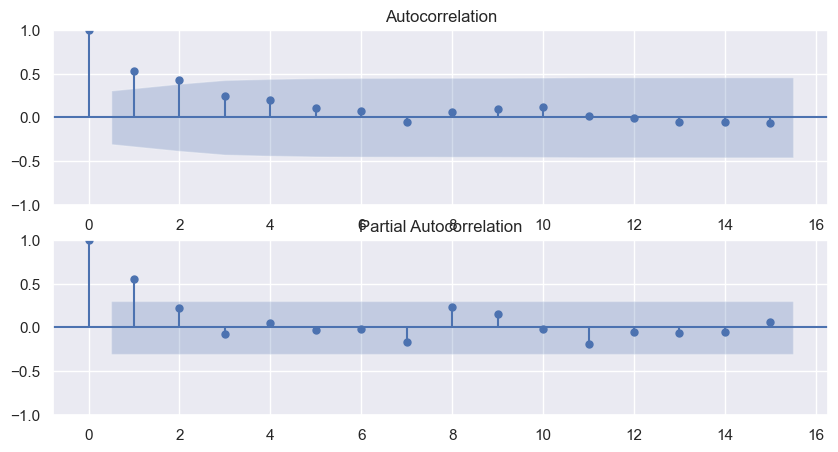

In [126]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sbe_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(sbe_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [127]:
# Check stationary
result = adfuller(sbe_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.166084
p-value: 0.022034
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [128]:
# Differencing
time_series_diff = sbe_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.232192
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


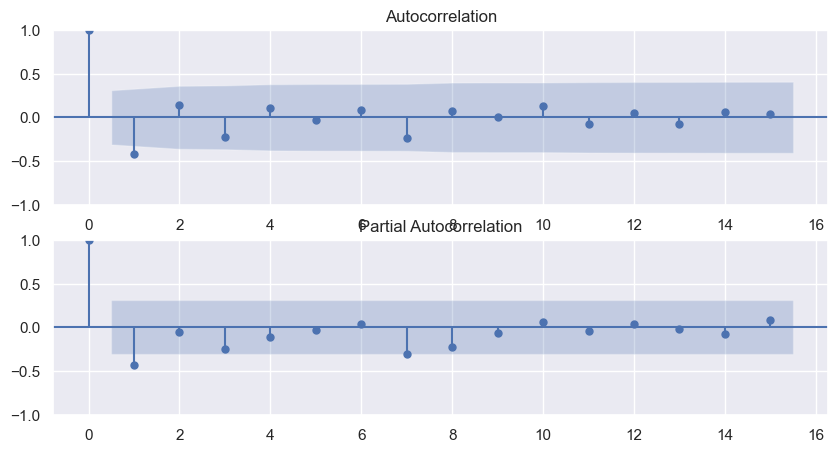

In [129]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [130]:
# load data
series = sbe_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

>Predicted=1.063, Expected=  1
>Predicted=1.191, Expected=  2
>Predicted=1.680, Expected=  1
>Predicted=1.468, Expected=  2
>Predicted=1.465, Expected=  1
RMSE: 0.392


In [131]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_sbe2 = pd.DataFrame()
predictionDf_sbe2['Year'] = list(range(1980, 2023))
predictionDf_sbe2 = predictionDf_sbe2.set_index('Year')
predictionDf_sbe2['ForecastResult'] = ForecastResult
predictionDf_sbe2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_sbe2.tail())

      ForecastResult  Price/Pound
Year                             
2018        1.679646     1.169265
2019        1.467724     1.654720
2020        1.465143     1.421295
2021        1.552229          NaN
2022        1.518892          NaN


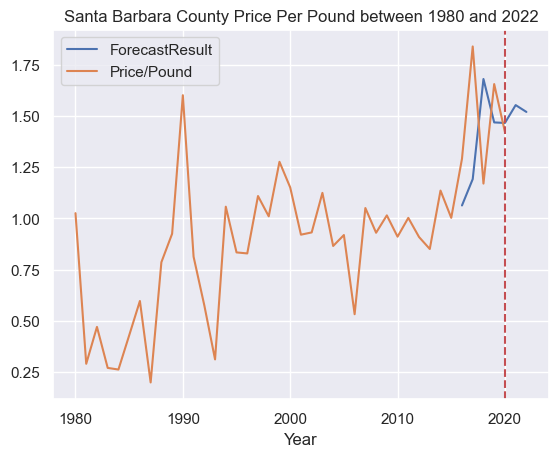

In [132]:
predictionDf_sbe2.plot()
plt.title('Santa Barbara County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [133]:
### San Luis Obispo County

In [134]:
slo_df = model_data1[model_data1['County'] == 'San Luis Obispo']
slo_df2 = slo_df[['Year','PriceP/U']]
print(slo_df2)

     Year  PriceP/U
390  1980  0.965000
379  1981  0.260000
367  1982  0.465000
355  1983  0.312000
343  1984  0.270000
331  1985  0.425000
320  1986  0.522500
309  1987  0.262500
298  1988  0.805500
287  1989  0.825000
276  1990  1.125500
267  1991  0.805500
258  1992  0.772000
249  1993  0.572500
239  1994  0.937500
229  1995  0.799000
219  1996  0.926500
209  1997  1.139000
199  1998  1.070500
189  1999  1.549500
179  2000  1.248000
169  2001  0.959500
159  2002  0.968000
149  2003  1.174630
139  2004  0.863115
129  2005  0.959915
119  2006  0.550300
110  2007  1.021595
101  2008  1.014385
92   2009  1.275670
83   2010  0.792005
74   2011  1.378980
65   2012  0.719490
57   2013  0.967225
49   2014  0.987565
41   2015  0.915820
33   2016  1.121305
25   2017  1.426070
17   2018  1.201695
10   2019  1.593240
3    2020  0.943380


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


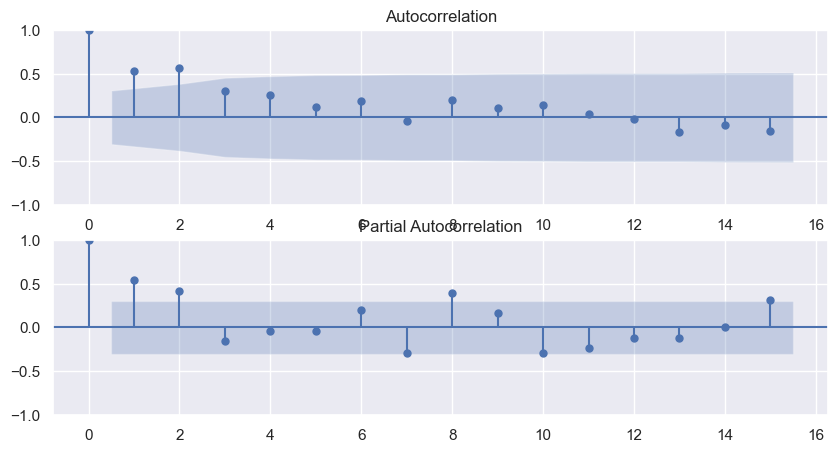

In [135]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(slo_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(slo_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [136]:
# Check stationary
result = adfuller(slo_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.785900
p-value: 0.387484
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


In [137]:
# Differencing
time_series_diff = slo_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.223096
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


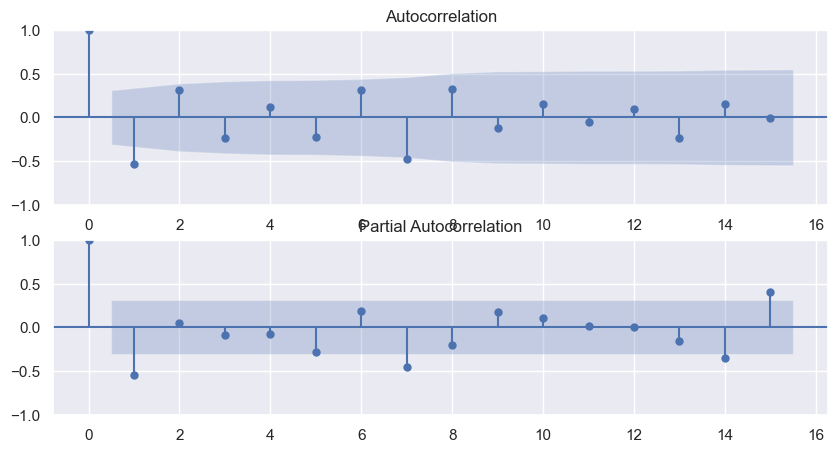

In [138]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [139]:
# load data
series = slo_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

>Predicted=0.964, Expected=  1
>Predicted=1.015, Expected=  1
>Predicted=1.303, Expected=  1
>Predicted=1.363, Expected=  2
>Predicted=1.386, Expected=  1
RMSE: 0.301


In [140]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_slo2 = pd.DataFrame()
predictionDf_slo2['Year'] = list(range(1980, 2023))
predictionDf_slo2 = predictionDf_slo2.set_index('Year')
predictionDf_slo2['ForecastResult'] = ForecastResult
predictionDf_slo2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_slo2.tail())

      ForecastResult  Price/Pound
Year                             
2018        1.302575     1.201695
2019        1.363151     1.593240
2020        1.385636     0.943380
2021        1.383247          NaN
2022        1.091613          NaN


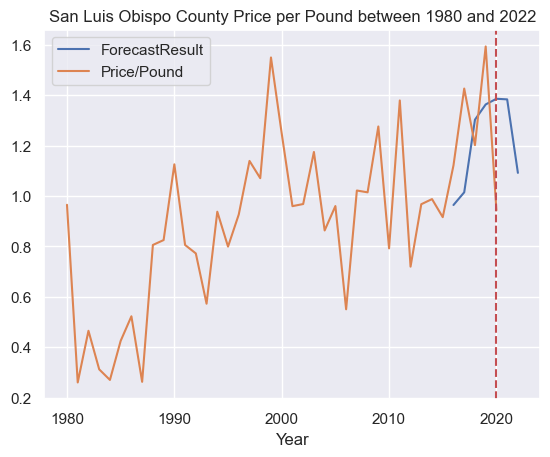

In [141]:
predictionDf_slo2.plot()
plt.title('San Luis Obispo County Price per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

The avocado state average per-unit price will increase in 2021 and then decrease in 2022. Ventura and San Luis Obispo Counties are good options for avocado vendors seeking large amounts of avocado quantities for lower prices. San Luis Obispo County holds one of the lowest costs for avocados and might be of interest to smaller businesses. Evaluating demand at a state level can help optimize avocado prices for each state.

## End